# Proyek Akhir: Menyelesaikan Permasalahan HR Perusahaan Jaya Jaya Maju

- Nama: Jihad Rafsanjani
- Email: rafsanjanijihad@gmail.com
- Id Dicoding: jihadr

## Persiapan

### Menyiapkan library yang dibutuhkan

In [ ]:
#Koneksi untuk Kaggle
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

### Menyiapkan data yang akan diguankan

## Data Understanding

In [48]:
#Untuk notebook pada kaggle
#df = pd.read_csv('/kaggle/input/jayajayamaju/employee_data.csv')
df = pd.read_csv('employee_data.csv')

In [49]:
# Cek struktur data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1470 non-null   object 
 4   DailyRate                 1470 non-null   int64  
 5   Department                1470 non-null   object 
 6   DistanceFromHome          1470 non-null   int64  
 7   Education                 1470 non-null   int64  
 8   EducationField            1470 non-null   object 
 9   EmployeeCount             1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement            1470 non-null   int64  
 14  JobLevel

In [ ]:
# Cek missing values
df.isna().sum()

In [ ]:
# Cek duplikasi
df.duplicated().sum()

In [ ]:
df.describe()

## Data Preparation / Preprocessing

In [50]:
#memisahkan data yang memiliki attrition dan tidak
# Data dengan label (untuk training & analisis)
df_labeled = df[df['Attrition'].notna()].copy()

# Data tanpa label (untuk prediksi)
df_unlabeled = df[df['Attrition'].isna()].copy()

print(df_labeled.shape)
print(df_unlabeled.shape)


(1058, 35)
(412, 35)


In [51]:
# Analisis faktor penyebab
df_labeled.groupby('OverTime')['Attrition'].mean()


OverTime
No     0.107856
Yes    0.319218
Name: Attrition, dtype: float64

In [52]:
# Cek kembali struktur
df_labeled.info()
df_unlabeled.info()

# Pastikan kolom sama (kecuali Attrition)
set(df_labeled.columns) - set(df_unlabeled.columns)


<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, 1 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1058 non-null   int64  
 1   Age                       1058 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1058 non-null   object 
 4   DailyRate                 1058 non-null   int64  
 5   Department                1058 non-null   object 
 6   DistanceFromHome          1058 non-null   int64  
 7   Education                 1058 non-null   int64  
 8   EducationField            1058 non-null   object 
 9   EmployeeCount             1058 non-null   int64  
 10  EnvironmentSatisfaction   1058 non-null   int64  
 11  Gender                    1058 non-null   object 
 12  HourlyRate                1058 non-null   int64  
 13  JobInvolvement            1058 non-null   int64  
 14  JobLevel     

set()

In [53]:
#membuang kolom yang tidak diperlukan
drop_cols = ['StandardHours', 'EmployeeCount','Over18']
cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus','Gender']

df_labeled = df_labeled.drop(columns=drop_cols)
df_unlabeled = df_unlabeled.drop(columns=drop_cols)


In [54]:
#menyesuaikan type data
df_labeled['Attrition'] = df_labeled['Attrition'].astype(int)
df_labeled['EmployeeId'] = df_labeled['EmployeeId'].astype(object)


In [55]:
#Pemisahan kolom
TARGET = 'Attrition'

ordinal_cols = [
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobLevel',
    'JobSatisfaction',
    'PerformanceRating',
    'RelationshipSatisfaction',
    'StockOptionLevel',
    'TrainingTimesLastYear',
    'WorkLifeBalance'
]

continuous_cols = [
    'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate',
    'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
    'PercentSalaryHike', 'TotalWorkingYears',
    'YearsAtCompany', 'YearsInCurrentRole',
    'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

In [56]:
#outlier handling hanya du continous column

def cap_outlier(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)

for col in continuous_cols:
    cap_outlier(df_labeled, col)
    cap_outlier(df_unlabeled, col)


In [57]:
#scaling untuk numerik continous

scaler = StandardScaler()

df_labeled[continuous_cols] = scaler.fit_transform(
    df_labeled[continuous_cols]
)

df_unlabeled[continuous_cols] = scaler.transform(
    df_unlabeled[continuous_cols]
)

In [58]:
df_labeled, df_unlabeled = df_labeled.align(
    df_unlabeled,
    join='left',
    axis=1,
    fill_value=0
)


In [59]:
df_labeled = pd.get_dummies(
    df_labeled,
    columns=cat_cols,
    drop_first=False
)

df_unlabeled = pd.get_dummies(
    df_unlabeled,
    columns=cat_cols,
    drop_first=False
)


In [60]:
encoded_cat_cols = [
    col for col in df_labeled.columns
    if any(col.startswith(cat + '_') for cat in cat_cols)
]

In [61]:
#penggabungan
feature_cols = ordinal_cols + continuous_cols + encoded_cat_cols

X_labeled = df_labeled[feature_cols]
y_labeled = df_labeled[TARGET]

X_unlabeled = df_unlabeled[feature_cols]

In [62]:
#validasi
df_labeled[TARGET].value_counts()
df_labeled[ordinal_cols].nunique()


Education                   5
EnvironmentSatisfaction     4
JobInvolvement              4
JobLevel                    5
JobSatisfaction             4
PerformanceRating           2
RelationshipSatisfaction    4
StockOptionLevel            4
TrainingTimesLastYear       7
WorkLifeBalance             4
dtype: int64

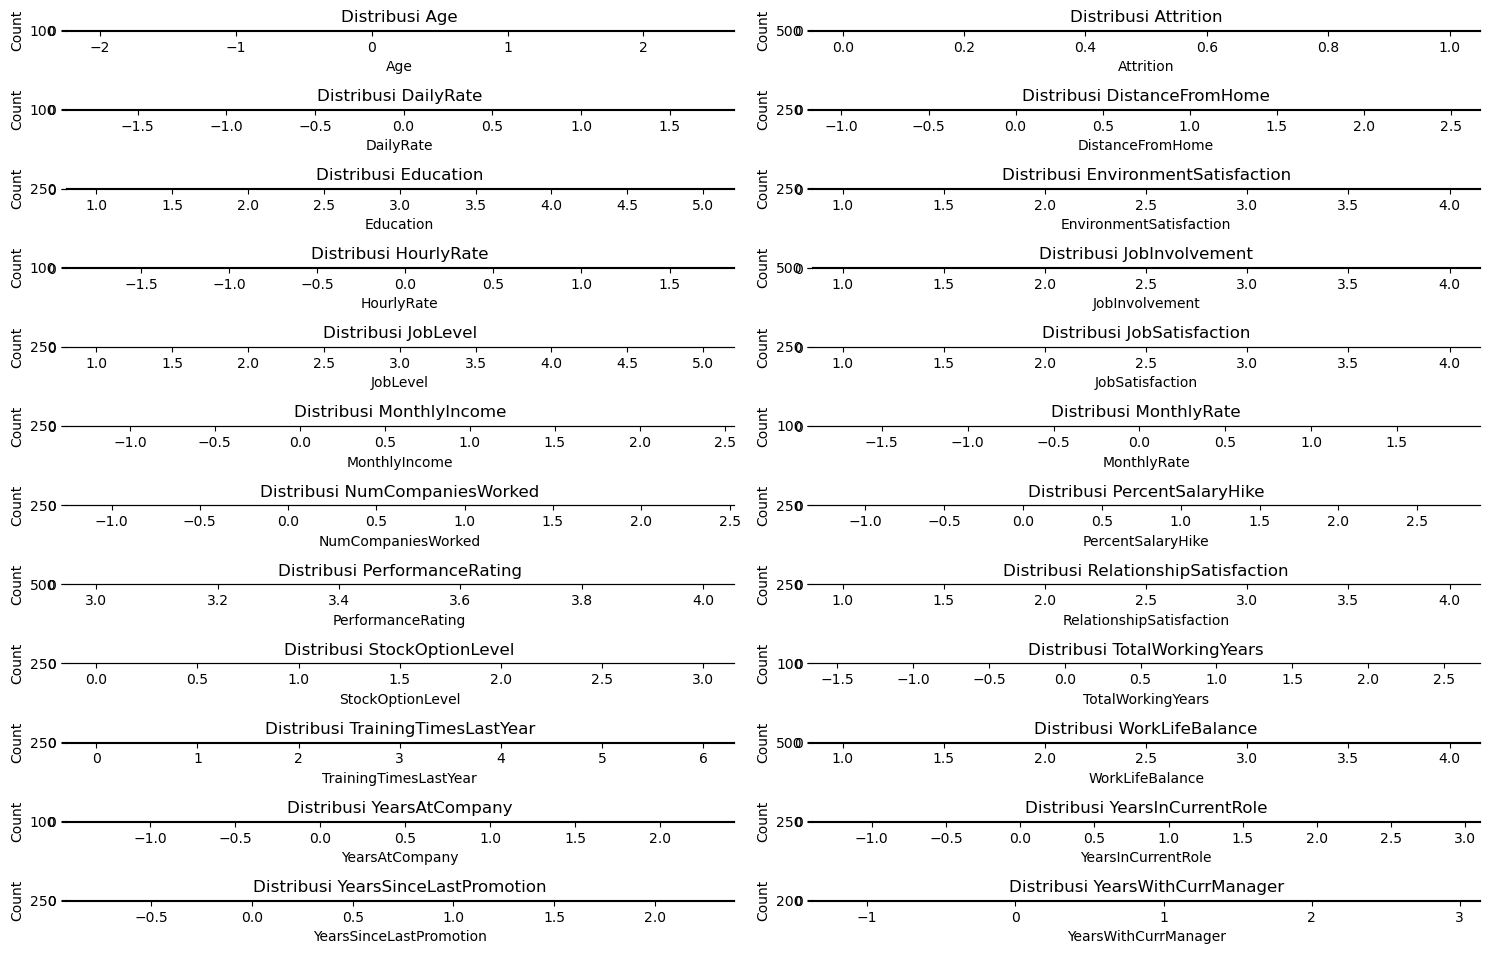

In [63]:
#cek distribusi fitur numerik

num_cols = df_labeled.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//2 + 1, 2, i)
    sns.histplot(df_labeled[col], kde=True, color='steelblue')
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

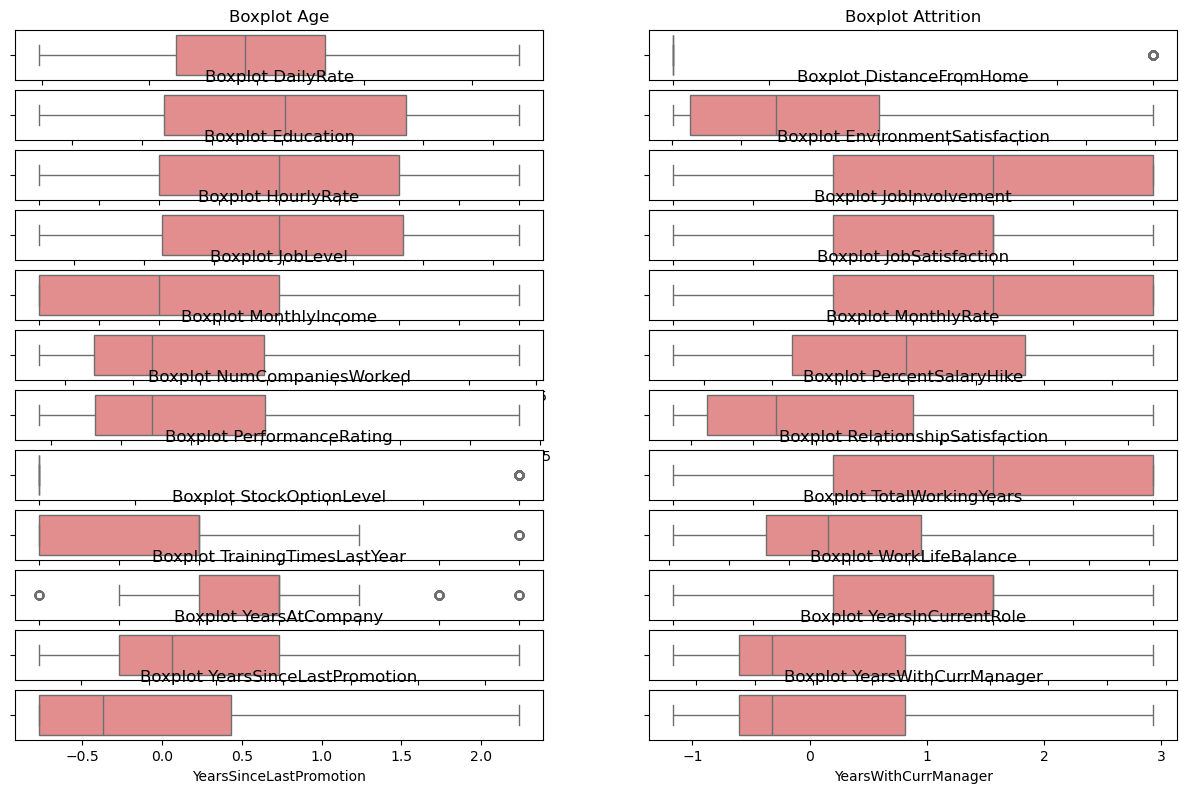

In [64]:
#Deteksi Outlier

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//2 + 1, 2, i)
    sns.boxplot(x=df_labeled[col], color='lightcoral')
    plt.title(f'Boxplot {col}')
plt.show()

In [65]:
df_labeled.value_counts('JobLevel')

JobLevel
1    394
2    364
3    165
4     80
5     55
Name: count, dtype: int64

In [66]:
df_labeled.head()

,EmployeeId,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Gender_Female,Gender_Male
1,2,-0.005929,1,0.811829,0.251560,2,1,-0.228580,1,2,...,False,False,False,False,False,False,True,False,True,False
2,3,1.482487,1,1.257596,-0.619433,4,1,-1.557631,3,1,...,False,False,True,False,False,False,True,False,False,True
3,4,0.525648,0,-0.623443,2.117973,3,3,0.559005,3,4,...,False,False,False,True,False,False,True,False,True,False
6,7,0.313018,0,0.770191,-0.992715,2,2,-0.425477,1,2,...,False,False,False,True,False,False,True,False,False,True
7,8,1.907749,1,-0.207067,-0.868288,3,4,0.608229,3,5,...,False,False,False,False,False,False,True,False,False,True


## Modeling

## Evaluation